### 卷积图神经网络（GCN）

GCN 来源于论文 : [SEMI-SUPERVISED CLASSIFICATION WITH GRAPH CONVOLUTIONAL NETWORKS](https://arxiv.org/pdf/1609.02907.pdf)

### 构造卷积图神经网络


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


class GCN(nn.Module):
    def __init__(self, num_features: int, num_classes: int, hidden_channels: object) -> object:
        super(GCN, self).__init__()
        # 设置随机种子
        torch.manual_seed(1234)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        """
        :param edge_index: 边的下标
        :param x: x [num_nodes, num_features]
        :return:
        """
        x = self.conv1(x, edge_index)  # [num_nodes, hidden_channels]
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)  # [num_nodes, num_classes]
        return x

In [2]:
# 读取数据集
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='dataset', name="Cora")
print(f'图的数量 : {len(dataset)}')

图的数量 : 1


In [3]:
### 获取第一张图
data = dataset[0]
# 获取图的特征
num_features = dataset.num_features
# 获取图的类别
num_classes = dataset.num_classes

print(f'图的特征数 : {num_features}')
print(f'图的类别数 : {num_classes}')

# 定义模型
model = GCN(num_features=num_features, num_classes=num_classes, hidden_channels=16)
print(model)

图的特征数 : 1433
图的类别数 : 7
GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


### 可视化由未经训练的GCN图神经网络生成的节点表征

D:\DevApp\anaconda3\envs\Graph_Network\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
D:\DevApp\anaconda3\envs\Graph_Network\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


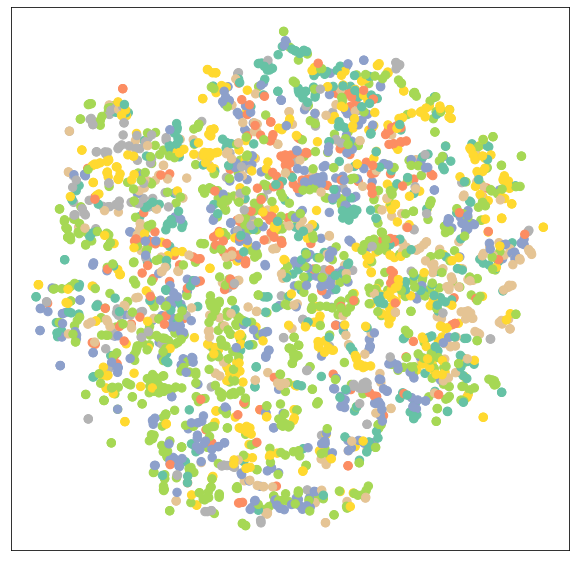

In [5]:
from torch_geometric_code.utils.draw_graph import visualize

model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

如上图所示 : 7维特征在映射到2维后出现同一类别的特征据集情况

### GCN图神经网络的训练

In [12]:
import torch
import torch.nn as nn

# 定义模型
model = GCN(num_features=num_features, num_classes=num_classes, hidden_channels=16)
# 定义Adam优化器和交叉熵损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()


def train():
    model.train()
    # 重置梯度
    optimizer.zero_grad()
    # forward
    out = model(data.x, data.edge_index)
    # loss值
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    # 反向传播
    loss.backward()
    # 参数更新
    optimizer.step()
    return loss

In [14]:
for epoch in range(1, 501):
    loss = train()
    if epoch % 100 == 0:
        print(f'Epoch: {epoch:03d} , Loss : {loss:.4f}')

Epoch: 100 , Loss : 0.0269
Epoch: 200 , Loss : 0.0194
Epoch: 300 , Loss : 0.0172
Epoch: 400 , Loss : 0.0118
Epoch: 500 , Loss : 0.0181


### GCN图神经网络的测试
在训练过程结束后，我们检测GCN图神经网络在测试集上的准确性

In [15]:
def test():
    model.eval()
    out = model(data.x, data.edge_index) # [num_nodes, num_classes]
    print(out.size())
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

In [16]:
test_acc = test()
print(f"准确度 : {test_acc:.4f}")

torch.Size([2708, 7])
准确度 : 0.8050


### 可视化由训练后的GCN图神经网络生成的节点表征

D:\DevApp\anaconda3\envs\Graph_Network\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
D:\DevApp\anaconda3\envs\Graph_Network\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


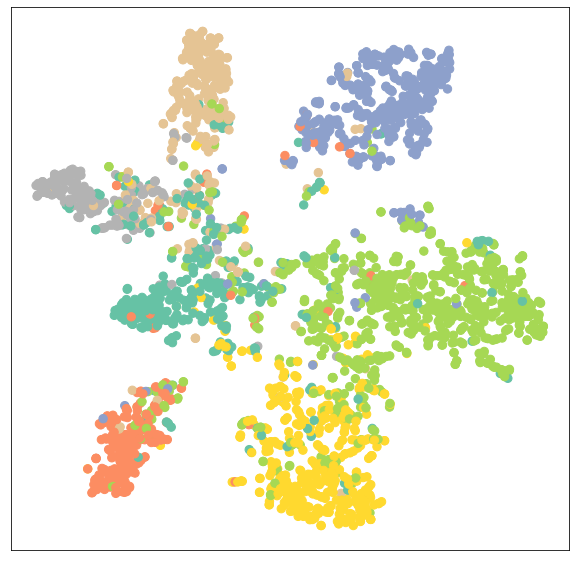

In [17]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)